## IMPORTANTO BIBLIOTECAS

In [7]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download puneet6060/intel-image-classification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 95% 328M/346M [00:10<00:00, 25.5MB/s]
100% 346M/346M [00:10<00:00, 35.0MB/s]


In [11]:
!unzip -v ./intel-image-classification.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
   16948  Defl:N    16495   3% 2019-10-18 05:52 e050b7f6  seg_train/seg_train/mountain/7539.jpg
    8318  Defl:N     7987   4% 2019-10-18 05:52 6afd06d9  seg_train/seg_train/mountain/7551.jpg
    8029  Defl:N     7699   4% 2019-10-18 05:52 e4b5dcd8  seg_train/seg_train/mountain/7560.jpg
   10892  Defl:N    10516   4% 2019-10-18 05:52 73a46a64  seg_train/seg_train/mountain/7565.jpg
   11674  Defl:N    11230   4% 2019-10-18 05:52 325eb1f8  seg_train/seg_train/mountain/7578.jpg
   14910  Defl:N    14539   3% 2019-10-18 05:52 b2a604f6  seg_train/seg_train/mountain/7581.jpg
    6908  Defl:N     6646   4% 2019-10-18 05:52 e8c29b8c  seg_train/seg_train/mountain/7586.jpg
   20167  Defl:N    19764   2% 2019-10-18 05:52 72955334  seg_train/seg_train/mountain/7647.jpg
   11952  Defl:N    11615   3% 2019-10-18 05:52 bc4d900d  seg_train/seg_train/mountain/7652.jpg
   11998  Defl:N    11646   3% 2019-10-18 05:52 a66a9eff  seg_train/seg_train

In [13]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing import image
from tensorflow import keras

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import os

## PARÂMETROS

In [14]:
percentege_test_size = 0.2
undersampling_size = 2100 # -1 para não fazer undersampling

# fig preprocessing
largura = 100
altura = 100
modo_de_cor = 'rgb' # rgb, grayscale, rgba
# fig preprocessing

# diretorio = '../dados classificacao imagens/star-wars/'
# diretorio = '../dados classificacao imagens/animais-kaggle/'
# diretorio = '../dados classificacao imagens/dataset-documentos-full/'
# diretorio = '../dados classificacao imagens/pneumonia/'
diretorio = '/content/seg_train/seg_train/'

### CARREGANDO DATASET

In [15]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]

targets = targets[1:len(targets)] # exclui o primeiro da lista pq é o próprio diretório

dados = []

class_to_int = {}

k = 0

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    class_to_int[classe] = k
    k+=1
    for img in imagens:
        i+=1
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img):
            dados.append([diretorio+classe+'/'+img,class_to_int[classe]])
        
        if(i == undersampling_size and undersampling_size != -1):
            break

dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados,columns=['image','target'])

df_dados['target'] = df_dados['target'].astype('int64', copy=False)

df_dados

,image,target
0,/content/seg_train/seg_train/street/12323.jpg,4
1,/content/seg_train/seg_train/sea/3361.jpg,5
2,/content/seg_train/seg_train/buildings/10831.jpg,2
3,/content/seg_train/seg_train/forest/6061.jpg,3
4,/content/seg_train/seg_train/buildings/13676.jpg,2
...,...,...
12595,/content/seg_train/seg_train/forest/11375.jpg,3
12596,/content/seg_train/seg_train/street/17490.jpg,4
12597,/content/seg_train/seg_train/mountain/8109.jpg,1
12598,/content/seg_train/seg_train/sea/10826.jpg,5


In [16]:
df_dados['target'].value_counts()

4    2100
5    2100
2    2100
3    2100
0    2100
1    2100
Name: target, dtype: int64

## PREPARANDO DADOS

In [17]:
def embedding(img_path,largura,altura,modo_de_cor):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)

    return embed

In [18]:
y_full = df_dados['target'].array.to_numpy()

X_full  = []
for x in dados:
    X_full.append(embedding(x[0],largura,altura,modo_de_cor))

X_full = np.array(X_full)


In [19]:
model_test_size = int(len(y_full) * percentege_test_size)

X_test, X_train = X_full[:model_test_size] / 255.0, X_full[model_test_size:] / 255.0
y_test, y_train = y_full[:model_test_size], y_full[model_test_size:]

## TREINANDO E VALIDANDO O MODELO

In [20]:
shape_entrada = (largura,altura,1)

if(modo_de_cor == 'rgb'):
    shape_entrada = (largura,altura,3)

if(modo_de_cor == 'rgba'):
    shape_entrada = (largura,altura,4)

model = keras.models.Sequential([
    
########## Conv
    
keras.layers.InputLayer(input_shape=shape_entrada),
keras.layers.Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'),
keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
keras.layers.Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'),
keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
keras.layers.BatchNormalization(),
keras.layers.Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'),
keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
keras.layers.BatchNormalization(),
keras.layers.Flatten(),
keras.layers.Dense(units=100, activation='relu'),
keras.layers.Dense(units=100, activation='relu'),
keras.layers.Dropout(0.25),

    
keras.layers.Dense(len(np.unique(y_train)), activation="softmax")
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 25)      1900      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 25)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 50)        31300     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 50)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 50)       200       
 ormalization)                                                   
                                                        

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
optimizer="adam",
metrics=["accuracy"])

In [23]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')]

callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, verbose=0, restore_best_weights=True))


history = model.fit(X_train, y_train, epochs=500,
                    validation_split=0.05,
                    callbacks=callbacks
                   )

Epoch 1/500
300/300 [==============================] - 16s 12ms/step - loss: 1.0619 - accuracy: 0.5944 - val_loss: 1.2505 - val_accuracy: 0.4742 - lr: 0.0010
Epoch 2/500
300/300 [==============================] - 3s 10ms/step - loss: 0.7636 - accuracy: 0.7172 - val_loss: 2.9112 - val_accuracy: 0.4127 - lr: 0.0010
Epoch 3/500
300/300 [==============================] - 3s 10ms/step - loss: 0.6361 - accuracy: 0.7722 - val_loss: 1.5223 - val_accuracy: 0.5456 - lr: 0.0010
Epoch 4/500
300/300 [==============================] - 3s 10ms/step - loss: 0.5564 - accuracy: 0.7975 - val_loss: 0.7420 - val_accuracy: 0.6885 - lr: 0.0010
Epoch 5/500
300/300 [==============================] - 3s 10ms/step - loss: 0.4862 - accuracy: 0.8255 - val_loss: 1.0021 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 6/500
300/300 [==============================] - 3s 10ms/step - loss: 0.4403 - accuracy: 0.8442 - val_loss: 0.5549 - val_accuracy: 0.7956 - lr: 0.0010
Epoch 7/500
300/300 [==============================] - 3s

## VALIDANDO DE FORMA MAIS ELABORADA

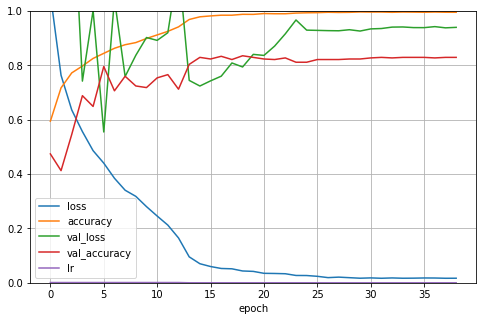

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('epoch')
plt.show()

In [25]:
model.evaluate(X_test, y_test)

79/79 [==============================] - 0s 6ms/step - loss: 0.8438 - accuracy: 0.8159


[0.8437911868095398, 0.8158730268478394]

## VISUALIZANDO A MATRIZ DE CONFUSÃO

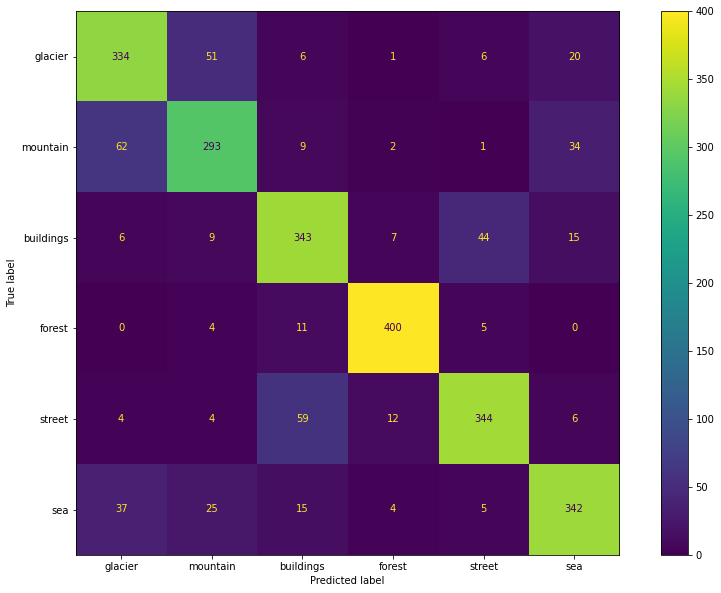

In [26]:
cm = confusion_matrix(y_test,np.argmax(model.predict(X_test), axis=-1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_to_int)

plt.rcParams['figure.figsize'] = [15, 10]

disp.plot()

plt.show()